# Deep Q Learning with the game 2048

This repository trains a q deep learning network from the game 2048 and plots a performance graph. The gamelogic of the game 2048 is based on the implementation from Georg Wiese on his [GitHub Repo](https://github.com/georgwiese/2048-rl) and can for instance be played [here](http://2048game.com/de/). The deep q learning code is loosely based on the implementation form this [GitHub Repo](https://github.com/keon/deep-q-learning) tutorial and was enhanced and adapted to include the game 2048.

## Overview

### Quickstart

To start training, scroll down to the Cell called "Train it".

### The game 2048

2048 is a single-player sliding block puzzle game developed by Gabriele Cirulli in 2014. The game represents a 4 × 4 grid where the value of each cell is a power of 2. An action can be any of the 4 movements: up, down, left right. When an action is performed, all cells move in the chosen direction. Any two adjacent cells with the same value (power of 2) along this direction merge to form one single cell with value equal to the sum of the two cells (i.e. the next power of 2). The objective of the game is to combine cells until reaching 2048. After each move, a new tile appears at a random empty cell. The game is finished/lost if all cells are full.
To get a quick feeling of the game it is recommended to check out the free online version [here](http://2048game.com/).

The game itself (gamelogic) of the game 2048 can be found in the folder gamelogic in file game.py.

### Strategies
2048 is a game which starts easy but becomes very hard for human players. Obviously merging tiles whenever you can will get you to a certain level, but to reach a high score (or maximum value of e.g. 2048) there needs to be more sophisticated strategies. One of the most famous is to put the highest numbers in one corner, like it is explained  [here](https://www.cnet.com/news/2048-starts-easy-gets-hard-heres-how-to-make-it-easy-again/). This technique also used by the most successfull 2048 AIs, for example [this one](http://www.randalolson.com/2015/04/27/artificial-intelligence-has-crushed-all-human-records-in-2048-heres-how-the-ai-pulled-it-off/) using an expectimax algorithm. 
The challenge of this game for AI is the high amount of possible states (more than 16^12) combined with the randomness introduced when spawning the new tiles.

### Q-Learning

#### Reward
Normally in games, the reward directly relates to the score of the game. In contrast in this game the official goal is to get a reach a 2048 tile (although the game does not stop there). 
The score is calculated in a way that it increases every time by the value of the newly merged tiles. For example is two 4s are merged the reward is 8.
This means the score partly represents the highest value on the board but gives also an incentive to have multiple high value tiles compared to just looking at the maximum value present at the board.

For our algorithm, we therefore implemented both versions of the reward, which results in a optimization of the score or a win-lose classification with a fixed target respectively.

As the results below show, we achieved similar results with both approaches.


#### Loss
In order to logically represent this intuition and train it, we need to express this as a formula that we can optimize on. The loss is just a value that indicates how far our prediction is from the actual target. For example, the prediction of the model could indicate that it sees more value in swiping left when in fact it can gain more reward by swiping upwards. We want to decrease this gap between the prediction and the target (loss). The loss is defined as:
In our case this is calculated with this oneliner in the act funtion:

$$ L = \frac{1}{2} \underbrace{	[r + \gamma*  max_{a'}Q(s',a')}_{\mathrm{target}} -\underbrace{Q(s,a)}_{\mathrm{prediction}}]^2 $$

whith the target looking like this in the code: <br>
target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))

## Implementation 
The repo consists of two parts: the learning part and the full programmed game of 2048.
The gamelogic of the game 2048 can be found in the folder gamelogic in file game.py.
The code can be run on both python 2.7 and 3.5 versions. 

### Libraries

Keras was used as neural network library. After testing with implementing tensorflow directly we found keras to be faster to code and easier to debug. 
Furthermore the simplicity of Keras allowed us to start from scratch and not getting biased from the implementation of [Georg Wiese](https://github.com/georgwiese/2048-rl).

<br>First, we import the libraries and the gamelogic class.

```python
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import json
import time
from shutil import copyfile
import parameters
import os

from gamelogic.game Game
```

### Parameters
Next, we define the number of episodes to play and set the hyperparameters.<br>
The parameters can be set in a seperate file parameters.py.
Every 100 episodes, key values are being saved in the folder data and can be plotted with the file plot.py.<br>
We implemented an epsilon greedy algorithm with a decay. As you can see, the agent only explores in the beginning and starts decaying at a given rate epsilon_decay.<br>

The hyperparameters used are explained below and an example is given for a successfull configuration using 100'000 episodes.<br>


<b>gamma</b> = 0.001<br>
In the case of taking one high maximum value as a reward, gamma can be set to be very low or even to 0 because it is very hard to reach a reward and there are no intermediate rewards so discounting should only be very small.
In the case of score as reward and therefore the existence of intermediate rewards, gamma can be higher.

<b>epsilon_decay</b> = 0.99992 <br>
Epsilon decay determines how fast epsilon decays.
We found 0.99992 is an apropriate amount, because it reaches the min_epsilon=0.01 after 60'000 episodes and our computing power restricts us to max 100'000 episodes.

<b>learning_rate</b> = 0.01 <br>
The learning_rate determines how fast gradient descent will find the solution but too large learning rate will lead to overshooting and not finding the optimal solution.
We had the best results with a standard learning_rate of 0.01.

<b>batch_size</b> = 32 <br>
This determines the size of the batches used to replay and therefore to train the network.
We found 32 to be used in most comparable problems and a batch size of 64 too slow down training too much without any improvements in the result.

<b>is_max_value_reward </b>= True<br>
This is the boolean value which can be set to either using the score (false) or the maximum value as a reward(true).

<b>max_value_reward_threshold</b> = 8<br>
This parameter determines the threshold which number the agent has to reach to get the reward. 
If this is set to 8, the agent has to reach a 2^9=512 tile to get the reward.

<b>max_value_reward_amount</b> = 1000<br>
This is only used if is_max_value_reward = True and determines the reward which the agent gets when reaching the threshold. Because discount rate is very small and there are no other rewards, this parameter does not have a big influence on the result.
  

This is how the parameter.py file is feeded into the agent: <br>
```python
EPISODES = 1000

path  = os.getcwd()

class DQNAgent:
    def __init__(self):
        self.state_size = 16
        self.action_size = 4 # (up, down, right, left)
        self.memory = deque(maxlen=5000000)
        self.gamma = parameters.gamma    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = parameters.epsilon_decay
        self.learning_rate = parameters.learning_rate
        self.model = self._build_model()
        self.batch_size = parameters.batch_size
        self.is_max_value_reward = parameters.is_max_value_reward
        self.max_value_reward_threshold = parameters.max_value_reward_threshold
        self.max_value_reward_amount = parameters.max_value_reward_amount
        self.output_name = parameters.output_name
```

### Artificial Neural Network

The deep network is a standard artificial neural network consisting of two fully connected hidden layers with 256 nodes each. As activation functions ReLu was used for all layers, which guarantees non vanishing gradients. The loss was computed using the mean squared error (mse). Bigger losses are therefore punished more. As optimizer we used Adam.

Keras does all the work of subtracting the target from the neural network output and squaring it. It also applies the learning rate we defined while creating the neural network model. This all happens inside the fit() function we see later. This function decreases the gap between our prediction to target by the learning rate. The approximation of the Q-value converges to the true Q-value as we repeat the updating process. The loss will decrease and the score will go up.

```python
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
```

### Remember

One of the challenges for DQN is that neural network used in the algorithm tends to forget the previous experiences as it overwrites them with new experiences. So we implemented a replay memory, stored as a list of previous experiences and observations to train the model with the previous experiences. We will call this array of experiences memory and use the remember() function to append state, action, reward, and next state to the memory.

In our example, the memory list will have a form of:

memory = [(state, action, reward, next_state, done)...]

The remember function will simply store states, actions and resulting rewards to the memory like below:

```python
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
```


### Game Step

The act method plays one move of a game. First we implement the epsilon-greedy algorithm and get the four Q-values (which are the output nodes of our neural network) associated with the four possible actions we can do in this move. We then compare these action values with the possible actions, since sometimes we are limited in the actions we can take. We choose the action with the highest Q value that we are allowed to take.

```python
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(game.available_actions())
        #forward feeding
        act_values = self.model.predict(state)
        #temporarily sets q-values of not available actions to -100 so they are not chosen
        if len(game.available_actions())< 4:
          temp = game.available_actions()
          for i in range(0, 4):
            if i not in temp:
              act_values[0][i] = -100
        #returns action with highest q-value
        return np.argmax(act_values[0])
```

### Replay
The replay function trains the neural network with experience from the memory. It first samples a minibatch from the memory. Each memory contains the current state, action, next state and its reward and a boolean done of each state of the minibatch, indicating whether the game is over.
The Q learning algorithm is implemented as:
```python
target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
```
where self.model.predict(next_state)[0] returns the Q-value of the next_state.

```python
self.model.fit(state, target_f, epochs=1, verbose=0)
```
trains one epoch by calculating the loss between the target q value and the predicted q value.
Finally, we apply epsilon decay.


```python
    def replay(self, batch_size):
        """trains the neural net with experiences from memory (minibatches)"""
        #samples mimibatch from memory
        minibatch = random.sample(self.memory, batch_size)
        #for each memory
        for state, action, reward, next_state, done in minibatch:
            #if its final state set target to the reward
            target = reward
            if not done:
                #set target according to formula
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            #gets all 4 predictions from current state
            target_f = self.model.predict(state)
            #takes the one action which was selected in batch
            target_f[0][action] = target
            #trains the model
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

```

### Loading and saving the weights
The weights can be loaded and saved, so training can be interrupted and continued.

```python

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


```

### Putting it all together
The main function loops through the episodes:




```python

    for e in range(EPISODES):
        game.new_game()
        state = game.state()
        state = np.reshape(state, [1, agent.state_size])
```





As long as the game is not over, the act function get's called to receive the calculated action, and the reward gets calculated. If is_max_value_reward is set to TRUE the reward gets calculated by getting the value of the maximum tile. We get this by looking up the highest value from the state variable, which is the playing field containing all tiles represented as a vector. <br>
If is_max_value_reward is set to FALSE it takes the squared score The boolean done checks, whether the game is over and breaks the loop if so, to continue to the next episode:



```python

  while not game.game_over():
            action = agent.act(state)
            reward = (game.do_action(action))**2
            if(agent.is_max_value_reward):
                reward = 0
                temp = game.state()
                temp_reshaped = np.reshape(temp, [1, agent.state_size])
                temp_max_value = np.amax(temp_reshaped[0])
                if temp_max_value > agent.max_value_reward_threshold:
                    reward = agent.max_value_reward_amount
            next_state = game.state()
            actions_available = game.available_actions()
            if len(actions_available) == 0: 
                done = True
            else:
                done = False
            next_state = np.reshape(next_state, [1, agent.state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                if (debug): print("no action available")
                states = game.state()
                states = np.reshape(state, [1, agent.state_size])
                max_value = np.amax(states[0])
                output_list.append([e, np.asscalar(max_value), np.asscalar(game.score()), agent.epsilon])
                if(debug):print("max_value: " + str(max_value))
                break
        print("episodes: " + str(e))
```






For plotting, we save the different parameters together with all the data into a json file:




```python

        if save_maxvalues:
            if e == 100:
                src = path + "/learn.py"
                dst = path + "/data/"+agent.output_name+"config.py"
                copyfile(src, dst)
                output_list.insert(0, "gamma: "+str(parameters.gamma)+" | epsilon decay: "+str(parameters.epsilon_decay)+" | learning rate: "+str(parameters.learning_rate)+"\n batch size: "+str(parameters.batch_size)+" | reward = maxVal: "+str(parameters.is_max_value_reward)+" | reward amount: "+str(parameters.max_value_reward_amount)+" | reward threshold: "+str(parameters.max_value_reward_threshold))
            if e % 100 == 0:
                with open(path + "/data/"+agent.output_name+"output.txt", "w") as outfile:
                    json.dump(output_list, outfile)

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 10000 == 0:
            timenow = time.strftime("%Y-%m-%d_%H-%M-%S")
            savepath = path + "/data/agent"+agent.output_name+timenow+"_Epi"+str(e)
            agent.save(savepath)

```

### Train it
Just execute the following cell. Can be executed at anytime, since values are being stored for plotting.

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import json
from gamelogic.game import Game
import time
from shutil import copyfile
import parameters
import os

EPISODES = 100000

path  = os.getcwd()

class DQNAgent:
    def __init__(self):
        self.state_size = 16
        self.action_size = 4 # (up, down, right, left)
        self.memory = deque(maxlen=5000000)
        self.gamma = parameters.gamma    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = parameters.epsilon_decay
        self.learning_rate = parameters.learning_rate
        self.model = self._build_model()
        self.batch_size = parameters.batch_size
        self.is_max_value_reward = parameters.is_max_value_reward
        self.max_value_reward_threshold = parameters.max_value_reward_threshold
        self.max_value_reward_amount = parameters.max_value_reward_amount
        self.output_name = parameters.output_name
        filename = path + "/data/"
        if not os.path.exists(filename):
            os.makedirs(filename)

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.action_size, activation='relu'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """algorithm tends to forget the previous experiences as it overwrites them with new experiences.
        Therefore we re-train the model with previous experiences."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(game.available_actions())
        #forward feeding
        act_values = self.model.predict(state)
        #sets q-values of not available actions to -100 so they are not chosen
        if len(game.available_actions())< 4:
          temp = game.available_actions()
          for i in range(0, 4):
            if i not in temp:
              act_values[0][i] = -100
        #returns action with highest q-value
        return np.argmax(act_values[0])
        #replace return with this for a random agent:
        #return random.choice(game.available_actions())

    def replay(self, batch_size):
        """trains the neural net with experiences from memory (minibatches)"""
        #samples mimibatch from memory
        minibatch = random.sample(self.memory, batch_size)
        #for each memory
        for state, action, reward, next_state, done in minibatch:
            #if its final state set target to the reward
            target = reward
            if not done:
                #set target according to formula
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            #gets all 4 predictions from current state
            target_f = self.model.predict(state)
            #takes the one action which was selected in batch
            target_f[0][action] = target
            #trains the model
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save(name)



if __name__ == "__main__":
    game = Game()
    agent = DQNAgent()
    # agent.load("./save/file")
    done = False
    batch_size = agent.batch_size
    debug = False
    save_maxvalues = True
    output_list = []


    for e in range(EPISODES):
        game.new_game()
        state = game.state()
        state = np.reshape(state, [1, agent.state_size])
        while not game.game_over():
            action = agent.act(state)
            reward = (game.do_action(action))**2
            if(agent.is_max_value_reward):
                reward = 0
                temp = game.state()
                temp_reshaped = np.reshape(temp, [1, agent.state_size])
                temp_max_value = np.amax(temp_reshaped[0])
                if temp_max_value > agent.max_value_reward_threshold:
                    reward = agent.max_value_reward_amount
            next_state = game.state()
            actions_available = game.available_actions()
            if len(actions_available) == 0:
                done = True
            else:
                done = False
            next_state = np.reshape(next_state, [1, agent.state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                if (debug): print("no action available")
                states = game.state()
                states = np.reshape(state, [1, agent.state_size])
                max_value = np.amax(states[0])
                output_list.append([e, np.asscalar(max_value), np.asscalar(game.score()), agent.epsilon])
                if(debug):print("max_value: " + str(max_value))
                break
        print("episodes: " + str(e))

        #save copy of configuration and the episode_maxvalue_data
        if save_maxvalues:
            if e == 100:
                output_list.insert(0, "gamma: "+str(parameters.gamma)+" | epsilon decay: "+str(parameters.epsilon_decay)+" | learning rate: "+str(parameters.learning_rate)+"\n batch size: "+str(parameters.batch_size)+" | reward = maxVal: "+str(parameters.is_max_value_reward)+" | reward amount: "+str(parameters.max_value_reward_amount)+" | reward threshold: "+str(parameters.max_value_reward_threshold))
            if e % 100 == 0:
                with open(path + "/data/"+agent.output_name+"output.txt", "w") as outfile:
                    json.dump(output_list, outfile)

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        if e % 10000 == 0:
            timenow = time.strftime("%Y-%m-%d_%H-%M-%S")
            savepath = path + "/data/checkpoint"
            agent.save(savepath)


episodes: 0
episodes: 1
episodes: 2
episodes: 3
episodes: 4
episodes: 5
episodes: 6
episodes: 7
episodes: 8
episodes: 9
episodes: 10
episodes: 11
episodes: 12
episodes: 13
episodes: 14
episodes: 15
episodes: 16
episodes: 17
episodes: 18
episodes: 19
episodes: 20
episodes: 21
episodes: 22
episodes: 23
episodes: 24
episodes: 25
episodes: 26
episodes: 27
episodes: 28
episodes: 29
episodes: 30
episodes: 31
episodes: 32
episodes: 33
episodes: 34
episodes: 35
episodes: 36
episodes: 37
episodes: 38
episodes: 39
episodes: 40
episodes: 41
episodes: 42
episodes: 43
episodes: 44
episodes: 45
episodes: 46
episodes: 47
episodes: 48
episodes: 49
episodes: 50
episodes: 51
episodes: 52
episodes: 53
episodes: 54
episodes: 55
episodes: 56
episodes: 57
episodes: 58
episodes: 59
episodes: 60
episodes: 61
episodes: 62
episodes: 63
episodes: 64
episodes: 65
episodes: 66
episodes: 67
episodes: 68
episodes: 69
episodes: 70
episodes: 71
episodes: 72
episodes: 73
episodes: 74
episodes: 75
episodes: 76
episodes:

KeyboardInterrupt: 

### Plotting
As Plotting helps a lot to get the hyperparameters right and see the performance of the agent, a plotting function was developed to easily turn the training-data to a plot.
To plot the values, just execute the following cell.
By default, the average score, the average max value and the decaying epsilon are being plotted taking an average from a sample of the size set as the parameter stepsize, for example the first point is the average of the first 100 scores if the stepsize is set to 100.<br>
If plot_max_instead_of_avg is set to TRUE, then instead of the average, the maximum values of every sample is plotted.<br>
The inputname sets the name of the json file for the input data and therefore has to match the parameter set in parameters.py at the time of learning.

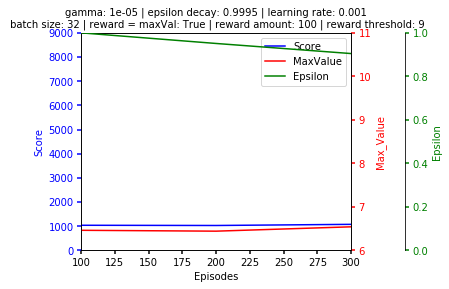

In [4]:
import json
import matplotlib.pyplot as plt
import os
#plotting info from https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html


#####SET PARAMETERS HERE######
stepsize = 100
plot_max_instead_of_avg = False
inputname = "test99"
debug = False
#####SET PARAMETERS HERE######

path = os.getcwd()

def plot():
    with open(path + '/data/'+inputname+'output.txt', "r") as infile:
      inputlist = json.load(infile)
      if (debug): print("path is: " + str(path))
      if (debug): print("list is: " + str(inputlist))
      #extract first item from list which is the configuration info

      plottitle = inputlist[0]
      inputlist.pop(0)
      calculate_data(inputlist, plottitle)



def calculate_data(inputlist, plottitle):
  number_of_steps = int(len(inputlist) / stepsize)
  if(debug):print("nr of steps is: " + str(number_of_steps))

  # EPISODES
  episodes_list = []
  for i in range(1, number_of_steps + 1):
    episodes_list.append(i * stepsize);
  if (debug):print("episode list: " + str(episodes_list))

  # Average Score
  avg_score_list = []
  for i in range(0, number_of_steps):
    sum = 0
    for j in range(0, stepsize):
      sum = sum + inputlist[stepsize * i + j][2]
    result = sum / (stepsize)
    avg_score_list.append(result)
  if (debug):print("avg_score_list: " + str(avg_score_list))

  # Average MaxValue
  avg_max_value_list = []
  for i in range(0, number_of_steps):
    sum = 0
    for j in range(0, stepsize):
      sum = sum + inputlist[stepsize * i + j][1]
    result = sum / float(stepsize)
    avg_max_value_list.append(result)
  if (debug):print("avg_max_value_list: " + str(avg_max_value_list))

  # Epsilon
  epsilon_list = []
  for i in range(0, number_of_steps):
    result = inputlist[stepsize * i][3]
    epsilon_list.append(result)
  if (debug):print("epsilon_list: " + str(epsilon_list))

  # MaxScore
  max_score_list = []
  # make now list consisting only of scores
  templist = [i[2] for i in inputlist]
  for i in range(0, number_of_steps):
    result = max(templist[i * stepsize:((i + 1) * stepsize)])
    max_score_list.append(result)
  if (debug):print("max_score: " + str(max_score_list))

  # MaxValue
  max_value_list = []
  # make now list consisting only of scores
  templist_two = [i[1] for i in inputlist]
  for i in range(0, number_of_steps):
    result = max(templist_two[i * stepsize:((i + 1) * stepsize)])
    max_value_list.append(result)
  if (debug):print("max_value_list: " + str(max_value_list))


  if(plot_max_instead_of_avg):
      plot_data(plottitle, max_x=len(inputlist)-(len(inputlist)%stepsize), para_episodes_list=episodes_list, para_value_list=max_value_list, para_score_list=max_score_list, para_epsilon_list=epsilon_list)
  else:
      plot_data(plottitle, max_x=len(inputlist)-(len(inputlist)%stepsize), para_episodes_list=episodes_list, para_value_list=avg_max_value_list, para_score_list=avg_score_list, para_epsilon_list=epsilon_list)


def plot_data(plottitle, max_x, para_episodes_list, para_value_list, para_score_list, para_epsilon_list):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)


    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)
    par1 = host.twinx()
    par2 = host.twinx()
    par2.spines["right"].set_position(("axes", 1.2))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    #Score
    p1, = host.plot(para_episodes_list, para_score_list, "b-", label="Score")
    #MaxValue
    p2, = par1.plot(para_episodes_list, para_value_list, "r-", label="MaxValue")
    #Epsilon
    p3, = par2.plot(para_episodes_list, para_epsilon_list, "g-", label="Epsilon")

    #Episodes
    host.set_xlim(stepsize, max_x)
    #Score
    host.set_ylim(0, 9000)
    #MaxValue
    par1.set_ylim(6, 11)
    #Epsilon
    par2.set_ylim(0, 1)


    host.set_xlabel("Episodes")
    host.set_ylabel("Score")
    par1.set_ylabel("Max_Value")
    par2.set_ylabel("Epsilon")
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)
    lines = [p1, p2, p3]
    host.legend(lines, [l.get_label() for l in lines])
    plt.title(plottitle, fontsize=10)
    additionalname = "_avg_"
    if (plot_max_instead_of_avg): additionalname = "_max_"

    figurepath = path + "/graphs/"
    if not os.path.exists(figurepath):
      os.makedirs(figurepath)
    fig.savefig(figurepath + str(inputname)+additionalname+"graph.pdf", bbox_inches='tight')
    plt.show()

plot()

## Results
Below is the comparison of 3 different configurations which we found to be the most successful configurations and a random moving agent.<br>
(a) used a score based reward and (b) and (c) maximum value-based rewards. The difference between the latter two is that we set (c) up for a long training time and therefore set a higher threshold for the tile-value which it has to reach to get a reward (10 instead of 9). <br>
The datapoints on the plots show the maximum or average results over 1000 episodes each.
Overall we see a significant improvement in score and max_value compared to a random agent.<br> Our agent after reaching an average maxVal of 7.25 and a average score of 2200 after 60’000 episodes compared to a average maxVal of 6.58 and average score of 1050 of a random agent.<br>
The graphs show that (c) performed worse than (b). We think this is because it is too unlikely to reach the defined reward threshold of 2^10 by random play and given the randomness in the game even harder to learn from those few occurences. <br>
The highest tile we could reach was 2^10 which is 1024. Considering the exponential difficulty of the game, reaching 2048 would need a lot more training and optimization.

<img src="notebook_img/plot_comparison.png" alt="Plots" style="width: 1000px;"/>

### Playing the game
During training, Keras saves a checkpoint of the model every 100 episodes. When running the following cell, One game is played using the latest checkpoint, displaying the game grid after every move. <br>
There is also the possiblily to load the agent (a) from the plots above to skip learning and use a trained agent right away.

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.models import load_model
from gamelogic.game import Game, ACTION_NAMES
import os
import tensorflow as tf
import numpy as np

path = os.getcwd()


def play_single_game():
    """Play a single game using the latest model snapshot"""
    game = Game()
    state_size = 16
    debug = True



    model = load_model(path + "/data/checkpoint")
  
    game.new_game()
    state = game.state()
    state = np.reshape(state, [1, state_size])
    while not game.game_over():
        # get action from highest q-value
        act_values = model.predict(state)
        if len(game.available_actions())< 4:
          temp = game.available_actions()
          for i in range(0, 4):
            if i not in temp:
              act_values[0][i] = -100
        #returns action with highest q-value
        action = np.argmax(act_values[0])
        
        reward = (game.do_action(action))**2
        next_state = game.state()
        actions_available = game.available_actions()
        if len(actions_available) == 0: 
            done = True
        else:
            done = False
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        print("Action:", ACTION_NAMES[action])
        print("Reward:", reward)
        game.print_state()

        if done:
            states = game.state()
            states = np.reshape(state, [1, state_size])
            max_value = np.amax(states[0])
            print("Score:", game.score())
            print("Max Value: " + str(2**max_value))
            print("Game over.")
            break
        


if __name__ == "__main__":
  """Main function."""
  play_single_game()

Action: left
Reward: 16
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
|    4|     |     |     |
-------------------------
|    2|     |     |     |
-------------------------
Action: up
Reward: 0
-------------------------
|    4|     |     |     |
-------------------------
|    2|     |    4|     |
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
Action: left
Reward: 0
-------------------------
|    4|     |     |     |
-------------------------
|    2|    4|     |    2|
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |
-------------------------
Action: left
Reward: 0
-------------------------
|    4|     |     |     |
-------------------------
|    2|    4|    2|    2|
-------------------------
|     |     |     |     |
-------------------------
|     |     |     |     |

Action: left
Reward: 16
-------------------------
|  128|   32|   16|    8|
-------------------------
|   64|   16|    8|    4|
-------------------------
|    2|   32|    4|    2|
-------------------------
|   16|    4|    2|     |
-------------------------
Action: right
Reward: 0
-------------------------
|  128|   32|   16|    8|
-------------------------
|   64|   16|    8|    4|
-------------------------
|    2|   32|    4|    2|
-------------------------
|    2|   16|    4|    2|
-------------------------
Action: up
Reward: 256
-------------------------
|  128|   32|   16|    8|
-------------------------
|   64|   16|    8|    4|
-------------------------
|    4|   32|    8|    4|
-------------------------
|     |   16|    2|     |
-------------------------
Action: left
Reward: 0
-------------------------
|  128|   32|   16|    8|
-------------------------
|   64|   16|    8|    4|
-------------------------
|    4|   32|    8|    4|
-------------------------
|   16|    2|    2|   

Action: left
Reward: 0
-------------------------
|  256|   64|   32|   16|
-------------------------
|    2|   32|   16|    8|
-------------------------
|   64|   16|    8|    2|
-------------------------
|    4|    2|     |    2|
-------------------------
Action: left
Reward: 16
-------------------------
|  256|   64|   32|   16|
-------------------------
|    2|   32|   16|    8|
-------------------------
|   64|   16|    8|    2|
-------------------------
|    4|    4|    2|     |
-------------------------
Action: left
Reward: 64
-------------------------
|  256|   64|   32|   16|
-------------------------
|    2|   32|   16|    8|
-------------------------
|   64|   16|    8|    2|
-------------------------
|    8|    2|     |    2|
-------------------------
Action: left
Reward: 16
-------------------------
|  256|   64|   32|   16|
-------------------------
|    2|   32|   16|    8|
-------------------------
|   64|   16|    8|    2|
-------------------------
|    8|    4|    2|  

### Conclusion
When we chose the game, we knew that it would be a hard one to play. Even for a human, there is no clear and obvious strategy in this game. <br>
As expected the results were not extremely high.
Training speed was slower then expected (3.5min/1000-game-episode), which was also caused by the rather slow hardware we were using. We also found that using a gpu did not increase the training speed, probably because of the low specs of the graphics card we used (gtx760 2GB).
This made it difficult to play through the high amount of possible hyperparameter configurations.
Still our agent is consistently beating a random player and is reaching a 1028 tile in some games, which is already rather hard to do for an unexperienced player.


